## О проекте
У меня в этом году были курсы по макроэкономике, поэтому я захотел проверить, некоторые утверждения, связанные со ставкой  в экономике США, и посмотреть насколько она влияет на фондовый рынок.

В проекте я брал данные из Yahoo finance, для этого использовал библиотеку yfinance, кроме этого использовал API для получения данных о ставке

Также для создания графиков, подсчета переменных использовались библиотеки pandas, scipy.stats, matpotlib, request, numpy

## Импорт библиотек

In [125]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from scipy.stats import pearsonr
import requests
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np


## Данные о индексах



В начале я решил рассмотреть несколько фондовых американских индексов, они хорошо отображают изменения всего рынка.
Я выбрал несколько наиболее крупных :
1.   GSPC - S&P 500
2.   DJI - Dow Jones Industrial Average
3.   IXIC - NASDAQ Composite
4.   NYA - NYSE Composite Index
5.   RUT - Russell 2000

Далее отоброжая их на одном на графике,  требуется нормировка(так как стоимость каждого индекса формируется по своему). И как раз на графике видим, что в целом все графики похожи, по движению, а разница, которая образуется, связана скорее с тем как они формируются(какие компании входят, какая индустрия).

Так же черная линия на графике - это среднее значение индексов, можно было конечно выбрать, какой - то определенный индекс, но сути это не поменяет)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


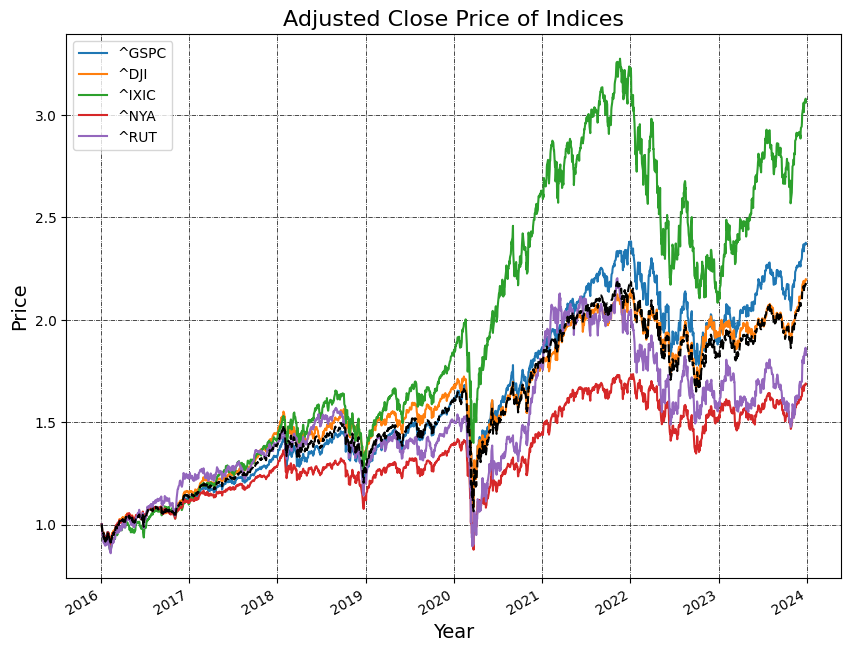

In [126]:
index_list = ['^GSPC','^DJI','^IXIC','^NYA','^RUT']
for index in index_list:
  data[index] = yf.download(index,'2016-01-01','2024-01-01')['Adj Close']

mean_values_index = data[index_list].mean(axis=1)
mean_values_index = mean_values_index / mean_values_index.iloc[0]

((data[index_list].pct_change()+1).cumprod()).plot(figsize=(10, 8))

plt.plot(mean_values_index.index, mean_values_index, 'k--', linewidth=1.5)

plt.legend()
plt.title("Adjusted Close Price of Indices", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

## Государственные облигации США




На Yahoo представлены данные о четырех видах облигаций это:

1.  IRX - 13-недельные
2.  FVX - 5-летние
3.  TNX - 10-летние
4.  TRX - 30-летние

Аналогично индексам, нормируем и рисуем график, но видим, что 13 недельные облигации слишком волотильны относительно остальных (они имеют такое же паттерн, но скачки и падения намного больше)

Поэтому строим график без IRX (аналогично индексам строим среднее значение (черная линия), хотя опять же можно было бы просто взять любую из этих трех оставшихся облигаций)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


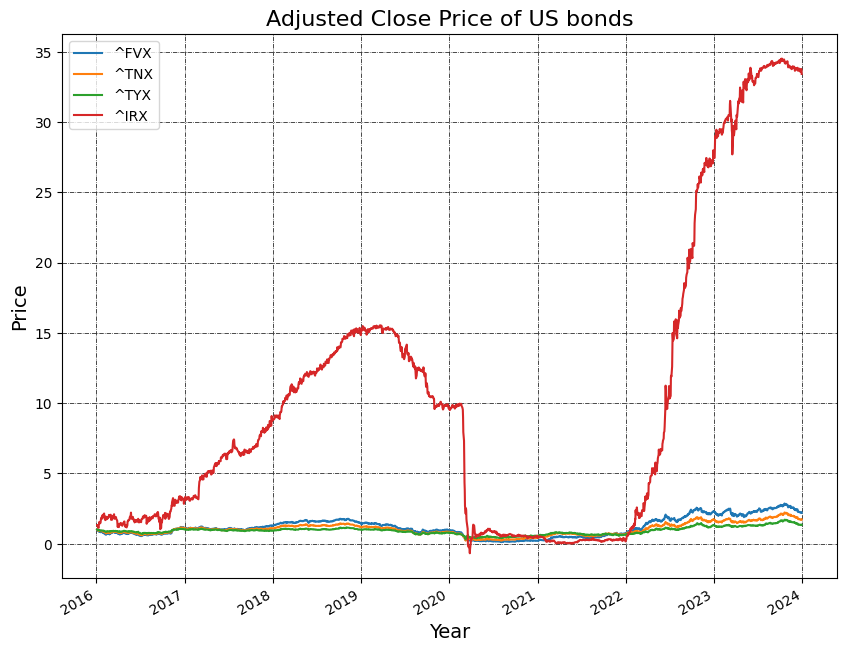

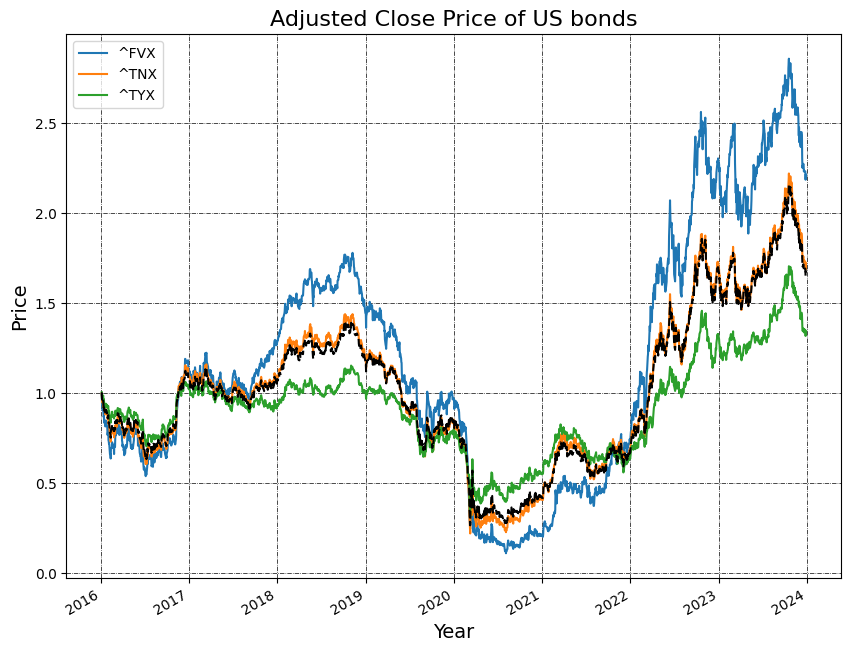

In [127]:
usbond_list = ['^FVX','^TNX','^TYX','^IRX']
for bond in usbond_list:
  data[bond] = yf.download(bond,'2016-01-01','2024-01-01')['Adj Close']

((data[usbond_list].pct_change()+1).cumprod()).plot(figsize=(10, 8))


plt.legend()
plt.title("Adjusted Close Price of US bonds", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

usbond_list.remove('^IRX')

mean_values_bond = data[usbond_list].mean(axis=1)
mean_values_bond = mean_values_bond / mean_values_bond.iloc[0]

((data[usbond_list].pct_change()+1).cumprod()).plot(figsize=(10, 8))

plt.plot(mean_values_bond.index, mean_values_bond, 'k--', linewidth=1.5)

plt.legend()
plt.title("Adjusted Close Price of US bonds", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()


df_mean_values_bond = pd.DataFrame(mean_values_bond)

df_mean_values_bond = df_mean_values_bond.reset_index()
df_mean_values_bond.columns = ['date', 'mean_values_bond']

df_mean_values_bond.to_csv('mean_values_bond.csv', index=False)

И тут можно подметить интересную теоретическую деталь, что чем меньше срок погашения облигации, тем более она волотильна, то есть все облигации в одинаковый момент растут, в одинаковый падают, лишь отличается на сколько. И видно что 30-летняя наиболее стабильна (приближина к прямой). И с уменьшением срока скачки растут ( у 13 недельной они самые сильные)


## Данные по ставке ФРС США

Так же, возьмем данные об изменениях банковской ставки в США. Для этого воспользуемся сайтом Federal Reserve Bank of St. Louis. И с помощью API получим данные и построим график. В теории он должен напоминать график гос. облигаций.

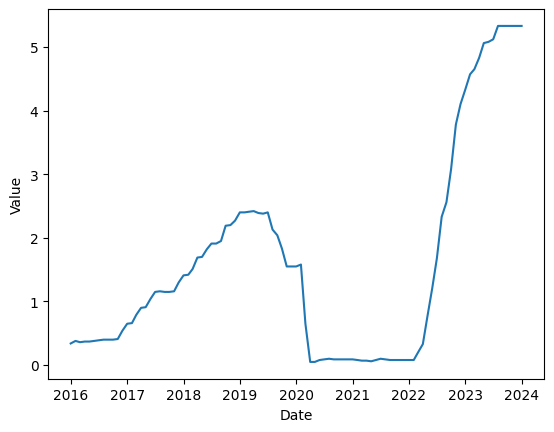

In [128]:
api_key = '0c12f15efda0f39d1981f68972b2e4ea'
tickers = 'FEDFUNDS'
start_date = '2016-01-01'
end_date = '2024-01-01'


url = f'https://api.stlouisfed.org/fred/series/observations?api_key={api_key}&series_id={tickers}&sort_order=desc&observation_start={start_date}&observation_end={end_date}'


response = requests.get(url)


xml_data = ET.fromstring(response.content)


df_fed_funds = pd.DataFrame([{
    'date': observation.attrib['date'],
    'value': float(observation.attrib['value'])
} for observation in xml_data.findall('observation')])


date = pd.to_datetime(df_fed_funds['date'])


df_fed_funds.to_csv('fed_funds_effective_rate.csv', index=False)

df_fed_funds = pd.read_csv('fed_funds_effective_rate.csv')


date = pd.to_datetime(df_fed_funds['date'])
plt.plot(date, df_fed_funds['value'])
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

Мы получаем график, достаточно сильно напоминающий графики облигаций (как и предполагалось), поэтому давайте посчитаем корреляцию между ними

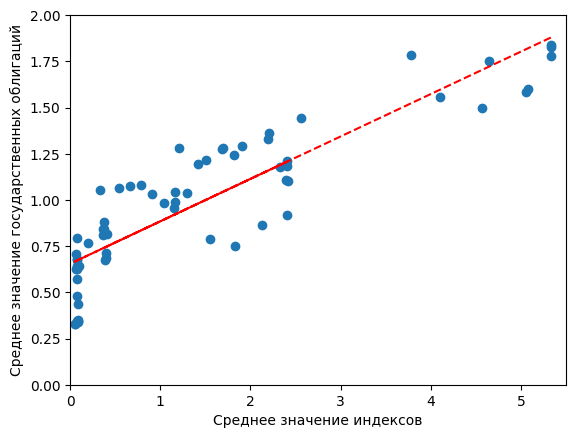

Коэффициент корреляции Пирсона: 0.8920


In [132]:
df_fed_funds = pd.read_csv('fed_funds_effective_rate.csv')
df_mean_values_bond = pd.read_csv('mean_values_bond.csv')


df_fed_funds['date'] = pd.to_datetime(df_fed_funds['date'])
df_mean_values_bond['date'] = pd.to_datetime(df_mean_values_bond['date'])


rate = pd.merge(df_fed_funds, df_mean_values_bond, on='date', how='inner')
rate_clean = rate.dropna(subset=['value', 'mean_values_bond'])


plt.scatter(rate_clean['value'], rate_clean['mean_values_bond'])
plt.xlabel('Среднее значение индексов')
plt.ylabel('Среднее значение государственных облигаций')
plt.xlim(0, 5.5)
plt.ylim(0, 2)

z = np.polyfit(rate_clean['value'], rate_clean['mean_values_bond'], 1)
p = np.poly1d(z)
plt.plot(rate_clean['value'], p(rate_clean['value']), "r--")

plt.show()

corr, _ = pearsonr(rate_clean['value'], rate_clean['mean_values_bond'])
print(f"Коэффициент корреляции Пирсона: {corr:.4f}")

Получилось, что величины коррелируют, что я в целом и хотел увидеть

## Корреляция индексов и облигаций

В целом регулирование ставки используют для контроля экономики, создавая стимулы либо больше инвестировать (при уменьшении ставки, инвестиции становтяся более привлекательны), либо обратные этому. Поэтому посмотрим также на корреляцию между облигациями и индексами, фактическими рынками (могла точно также быть ставка ФРС, но данных меньше, так как изменения реже)

Только здесь возникает, проблема, что данные имеют пустые ячейки, поэтому требуется их почистить и сделать так, чтобы были одинакового размера, чтобы функции работали

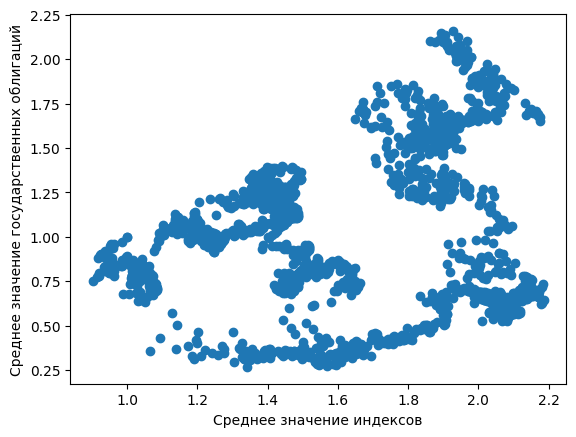

Коэффициент корреляции Пирсона: 0.2162


In [134]:
comp = pd.concat([mean_values_index, mean_values_bond], axis=1)

comp_clean = comp.dropna(subset=[0,1])

plt.scatter(comp_clean[0], comp_clean[1])


plt.xlabel('Среднее значение индексов')
plt.ylabel('Среднее значение государственных облигаций')

plt.show()

corr, _ = pearsonr(comp_clean[0], comp_clean[1])
print(f"Коэффициент корреляции Пирсона: {corr:.4f}")

Видно, что здесь прямой корреляции нет, скорее всего существует влияние ставки на рынок, но в случае с Американским рынком (самый большой и большое количество иностранных участников) влияние крайне незначительно